In [72]:
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, pick_types, events_from_annotations, concatenate_epochs
from mne.time_frequency import psd_welch
import scipy.signal
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import numpy as np
import pandas

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# Preprocessing

Before proceeding to feature extraction, we first need to load data, apply the annotations to it, filter the useful annotations and apply some filters.

In [73]:
%matplotlib inline
subjects = list(range(1,50))
runs = [4, 8, 12]
SELECTED_CHANNELS = {
    # 'CZ': 10,
    # 'FC2': 4,
    # 'CP2': 18, 
    'C4': 12, 
    # 'FC6': 6, 
    # 'CP6': 20, 
    # 'T8': 41, 
    'AFZ': 26,
    'C3': 8,
}
EPOCH_DURATION = 2
tmin = -0.5 * EPOCH_DURATION
tmax = 0.5 * EPOCH_DURATION

event_id = { 
    'T0': 1,
    'T1': 2,
}

all_subjects_epochs = []


for subject in subjects:
    raw_filename = eegbci.load_data(subject, runs)
    raw_edf = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_filename])
    
    eegbci.standardize(raw_edf) # channels name
    raw_edf.rename_channels(lambda x: x.strip('.')) # remove dot from channel name
    
    raw_edf.pick(picks=list(SELECTED_CHANNELS.values()))
    events, annotations = events_from_annotations(raw_edf, event_id=event_id)
    epochs = Epochs(raw_edf, events=events, event_id=event_id, tmin=tmin, tmax=tmax, preload=True, detrend=None)
    all_subjects_epochs.append(epochs)

    print("Nb of events: ", len(raw_edf.annotations))
    print("Duration: ", set(raw_edf.annotations.duration))
    print("Description: ", set(raw_edf.annotations.description))
    print(raw_edf.annotations.onset)

epochs = concatenate_epochs(all_subjects_epochs)
epochs

Extracting EDF parameters from C:\Users\Sara\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Sara\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Sara\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1']
Not setting metadata
Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 68 events and 321 original time points ...
3 bad ep

<Epochs |  584 events (all good), -1 - 1 sec, baseline [None, 0], ~12.9 MB, data loaded,
 'T0': 378
 'T1': 206>

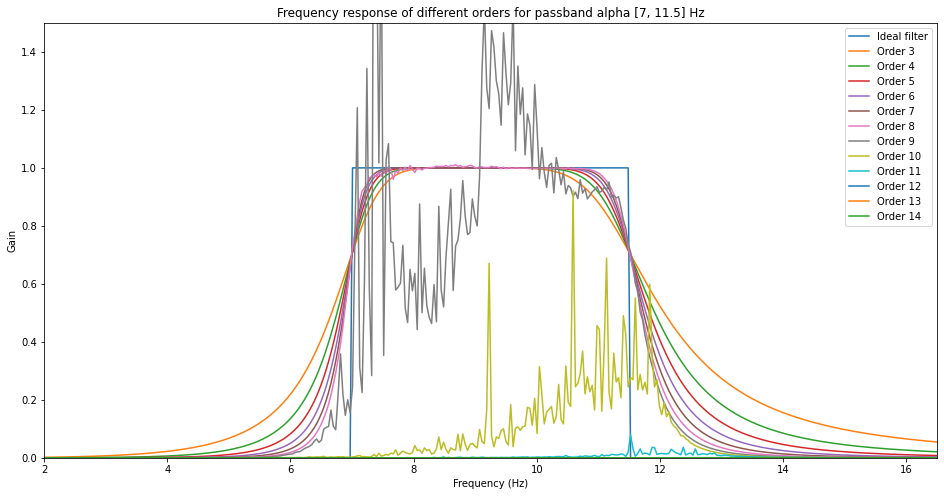

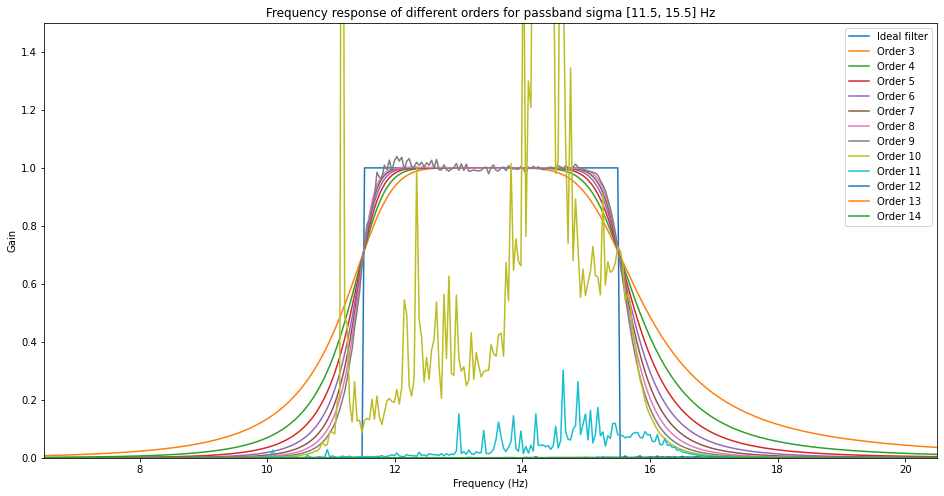

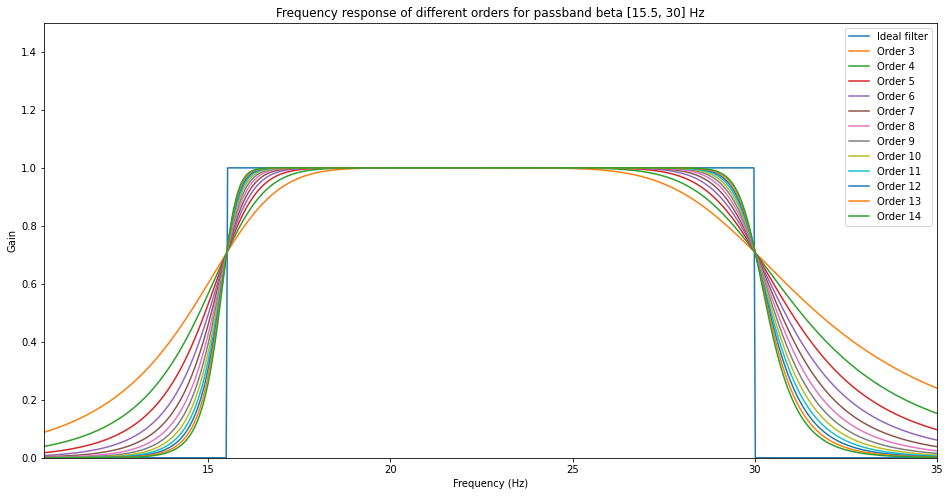

In [74]:
SAMPLING_FREQ = 160
NYQUIST_FREQ = SAMPLING_FREQ/2
WOR_N = 2056

FREQ_BANDS = {
    'alpha': [7, 11.5],
    'sigma': [11.5, 15.5],
    'beta': [15.5, 30],
}

epochs_sub_bands = dict.fromkeys(FREQ_BANDS.keys())
kernels = dict.fromkeys(FREQ_BANDS.keys())

for key, freq_range in FREQ_BANDS.items():
    fig, ax = plt.subplots(figsize = (16, 8))
    lower_bound = freq_range[0]/NYQUIST_FREQ
    upper_bound = freq_range[1]/NYQUIST_FREQ
    hz = np.linspace(0, NYQUIST_FREQ, WOR_N)
    ideal_filter = [1 if freq_range[0] <= f <= freq_range[1] else 0 for f in hz]
    ax.plot(hz, ideal_filter, label="Ideal filter")
    kernels[key] = {}
    for order in range(3,15):
        b, a = scipy.signal.butter(order, [lower_bound, upper_bound], btype='bandpass')
        w, h = scipy.signal.freqz(b, a, worN=WOR_N)
        ax.plot(hz, abs(h), label=f"Order {order}")
        ax.set_ylim([0, 1.5])
        ax.set_xlim([freq_range[0] - 5, freq_range[1] + 5])
        kernels[key][order] = (b, a)

    ax.legend()
    ax.set_title(f"Frequency response of different orders for passband {key} {freq_range} Hz")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Gain")
    plt.show()

In [75]:
ORDERS = {
    'alpha': 7,
    'sigma': 8,
    'beta': 14,
}

for key, freq_range in FREQ_BANDS.items():
    l_freq = freq_range[0]/NYQUIST_FREQ
    h_freq = freq_range[1]/NYQUIST_FREQ
    b = kernels[key][ORDERS[key]][0]
    a = kernels[key][ORDERS[key]][1]
    epochs_sub_bands[key] = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': order, 'ftype': 'butter','a': a,'b': b}, verbose=False)

fig, ax = plt.subplots(figsize=(19,6))

original_epoch = epochs['T0'][0].get_data().squeeze()[0]
x = np.linspace(0.0, EPOCH_DURATION, len(original_epoch))
ax.plot(x, original_epoch, label="Original signal")

reconstituted_signal = np.zeros(len(original_epoch))
for key in FREQ_BANDS.keys():
    reconstituted_signal += epochs_sub_bands[key]['T0'][0].get_data().squeeze()[0]

ax.plot(x, reconstituted_signal, label="Reconstituted signal")

LinAlgError: Eigenvalues did not converge

In [44]:
#l_freq = FREQ_BANDS['alpha_sigma_beta'][0]/NYQUIST_FREQ
#h_freq = FREQ_BANDS['alpha_sigma_beta'][1]/NYQUIST_FREQ
#b = kernels['alpha_sigma_beta'][ORDERS['alpha_sigma_beta']][0]
#a = kernels['alpha_sigma_beta'][ORDERS['alpha_sigma_beta']][1]
#alpha_epochs = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': ORDERS['alpha'], 'ftype': 'butter','a': a,'b': b}, verbose=False)

#sigma_epochs = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': ORDERS['sigma'], 'ftype': 'butter','a': a,'b': b}, verbose=False)

#beta_epochs = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': ORDERS[''], 'ftype': 'butter','a': a,'b': b}, verbose=False)

#filtered_epoch = filtered_epochs['T0'][0].get_data().squeeze()[0]
#filtered_epoch

In [45]:
#fig, ax = plt.subplots(figsize=(19,6))
#x = np.linspace(0.0, EPOCH_D URATION, len(original_epoch))
#ax.plot(x, filtered_epoch, label='Filtered Epoch')
#ax.plot(x, reconstituted_signal, label="Reconstituted signal")
#ax.legend()

This last plot shows that using epochs.filter(...) is exactly the same as using scipy to filter our data

# Feature extraction

Now, we need to extract the useful features to predict if left hand is closed or relaxed. 

## Spectral features

Let's check out frequency features

In [46]:
def get_psds_from_epochs(epochs):
    """Extracts power spectrum densities from epochs
    Returns
    --------
    psds with associated frequencies calculated with the welch method.
    """
    psds, freqs = psd_welch(epochs, fmin=7, fmax=30.)
    return psds, freqs

get_psds_from_epochs_transformer = FunctionTransformer(get_psds_from_epochs, validate=False)

In [47]:
def get_mean_psds(psds_with_freqs, are_relative=False):
    """EEG power band feature extraction.
    Input
    -------
    psds_with_freqs: tuple which contains
            - (nb_epochs, nb_chan=1, nb_freqs) psds amplitudes
            - (nb_freqs,) corresponding frequency values
            
    are_relative: boolean which indicates if the mean band powers
        for each subband are relative to the total power or not.

    Returns
    -------
    X : numpy array of shape [n_samples, nb_subband=5]
        Transformed data.
    """
    psds = psds_with_freqs[0]
    freqs = psds_with_freqs[1]
    
    if are_relative:
        psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

absolute_mean_psds_transformer = FunctionTransformer(get_mean_psds, validate=False)
relative_mean_psds_transformer = FunctionTransformer(lambda psds_with_freq: get_mean_psds(psds_with_freq, are_relative=True), validate=False)


In [48]:
frequency_domain_feature_union = FeatureUnion([
    ('absolute_mean_power_band', absolute_mean_psds_transformer),
    ('relative_mean_power_band', relative_mean_psds_transformer),
], n_jobs=1)

frequency_domain_pipeline = Pipeline([
    ('get_psds_from_epochs', get_psds_from_epochs_transformer),
    ('frequency_domain_features', frequency_domain_feature_union)
])

## Time domain features

Let's use each of our subbands to calculate our time domain features


In [49]:
def get_transformer(get_feature):
    
    def get_one_feature_per_epoch(X, get_feature):
        """
        X: Input matrix (nb_epochs, sampling_rate*epoch_length)
        get_feature: callable 
            generates one feature for each epoch

        returns matrix (nb_epoch,1)
        """
        return [[get_feature(epoch)] for epoch in X]

    return lambda X: get_one_feature_per_epoch(X, get_feature)

In [50]:
mean_transformer = FunctionTransformer(get_transformer(np.mean), validate=True)
std_transformer = FunctionTransformer(get_transformer(np.std), validate=True)
skew_transformer = FunctionTransformer(get_transformer(skew), validate=True)
kurtosis_transformer = FunctionTransformer(get_transformer(kurtosis), validate=True)

In [51]:
def get_signal_mean_energy(signal):
    """
    signal: array of (nb_sample_per_epoch,)
    """
    return np.sum(signal**2)*1e6

mean_energy_transformer = FunctionTransformer(get_transformer(get_signal_mean_energy), validate=True)

In [52]:
time_domain_feature_union = FeatureUnion([
    ('mean', mean_transformer),
    ('std', std_transformer),
    ('skew', skew_transformer),
    ('kurtosis', kurtosis_transformer),
    ('mean_energy', mean_energy_transformer),
], n_jobs=1)

## Sub-bands extraction
___

In [53]:
def get_data_from_epochs(epochs):
    """
    epochs: mne.Epochs
    
    returns np array of shape (nb_epochs, sampling_rate*epoch_length)
    """
    return epochs.get_data().squeeze()

get_data_from_epochs_transformer = FunctionTransformer(get_data_from_epochs, validate=False)


def get_epochs_per_subband(subband):
    freq_range = FREQ_BANDS[subband]

    def filter_freq_band_on_epochs(epochs):
        l_freq = freq_range[0]/NYQUIST_FREQ
        h_freq = freq_range[1]/NYQUIST_FREQ
        b = kernels[subband][ORDERS[subband]][0]
        a = kernels[subband][ORDERS[subband]][1]
        return epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': order, 'ftype': 'butter','a': a,'b': b}, verbose=False)

    return Pipeline([
        ('filter', FunctionTransformer(filter_freq_band_on_epochs, validate=False)),
        ('epochs_to_data', get_data_from_epochs_transformer),
        ('time_domain_features', time_domain_feature_union)
    ])

In [54]:
print(epochs.info)
def drop_channels(epochs, chan_to_keep):
    return epochs.copy().drop_channels([chan for chan in epochs.info['ch_names'] if chan != chan_to_keep])


<Info | 7 non-empty values
 bads: []
 ch_names: Cz, FC2, CP2, C4, FC6, CP6, T8, AFz, C3
 chs: 9 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 9
 projs: []
 sfreq: 160.0 Hz
>


## Extraction

In [55]:
feature_union = FeatureUnion([
    ('frequency_domain', frequency_domain_pipeline),
    ('subband_feature_union', FeatureUnion([(f'subband_{subband}', get_epochs_per_subband(subband)) for subband in FREQ_BANDS.keys()], n_jobs=1))
], n_jobs=1)

In [56]:
X = []
Y = epochs.events[:, -1] - 1
for chan in epochs.info['ch_names']:
    chan_epoch = drop_channels(epochs, chan)
    print(f'----- Feature extraction for channel {chan} -----')
    print(chan_epoch)
    X.append(feature_union.transform(chan_epoch))

X = np.hstack(X)

print(f'Y shape {np.array(Y).shape}')
print(f'X shape {np.hstack(X).shape}')

----- Feature extraction for channel Cz -----
<Epochs |  584 events (all good), -1 - 1 sec, baseline [None, 0], ~1.4 MB, data loaded,
 'T0': 378
 'T1': 206>
Effective window size : 1.600 (s)
----- Feature extraction for channel FC2 -----
<Epochs |  584 events (all good), -1 - 1 sec, baseline [None, 0], ~1.4 MB, data loaded,
 'T0': 378
 'T1': 206>
Effective window size : 1.600 (s)
----- Feature extraction for channel CP2 -----
<Epochs |  584 events (all good), -1 - 1 sec, baseline [None, 0], ~1.4 MB, data loaded,
 'T0': 378
 'T1': 206>
Effective window size : 1.600 (s)
----- Feature extraction for channel C4 -----
<Epochs |  584 events (all good), -1 - 1 sec, baseline [None, 0], ~1.4 MB, data loaded,
 'T0': 378
 'T1': 206>
Effective window size : 1.600 (s)
----- Feature extraction for channel FC6 -----
<Epochs |  584 events (all good), -1 - 1 sec, baseline [None, 0], ~1.4 MB, data loaded,
 'T0': 378
 'T1': 206>
Effective window size : 1.600 (s)
----- Feature extraction for channel CP6 -

## Classifier
___

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.19, random_state=42)

In [58]:
print(X_train)

[[ 1.15048474e-11  1.34067868e-11  1.06046163e-11 ... -4.28956213e-02
   8.11314523e-01  2.37821348e-02]
 [ 6.60747758e-12  5.56131043e-12  1.89209746e-12 ...  4.41730239e-02
  -2.05902872e-01  1.56058897e-02]
 [ 6.10377691e-11  4.81052282e-11  2.36528882e-11 ... -2.43801430e-01
   2.73609346e+00  7.83238620e-02]
 ...
 [ 7.82507495e-12  4.39193895e-12  1.59617781e-12 ... -3.30996113e-01
   1.77993840e+00  1.20717600e-02]
 [ 1.53442564e-10  3.18883248e-11  3.36464273e-12 ...  1.25422604e-03
   6.17733596e-02  1.14203151e-02]
 [ 9.26085927e-11  3.14342242e-11  1.08654869e-11 ...  7.07453042e-03
   2.80571408e-01  2.41069816e-02]]


# Logistic Regression


In [59]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()), ('logistic_Regression', LogisticRegression(n_jobs=-1)) ])

In [60]:
scores = cross_validate(
    estimator=pipeline,
    X=X_train,
    y= y_train,
    cv=KFold(n_splits=5),
    n_jobs=-1,
    scoring={
        "accuracy": 'accuracy',
        "f1-score-macro": 'f1_macro',
        "f1-score-weighted": 'f1_weighted',
    },
)
scores

{'fit_time': array([0.0757947 , 0.07679582, 0.08876228, 0.06881309, 0.08677697]),
 'score_time': array([0.00498676, 0.00599027, 0.0039897 , 0.00598812, 0.00497818]),
 'test_accuracy': array([0.57894737, 0.65263158, 0.68421053, 0.67021277, 0.68085106]),
 'test_f1-score-macro': array([0.48257081, 0.56824129, 0.55635118, 0.56028369, 0.56827924]),
 'test_f1-score-weighted': array([0.541337  , 0.60239926, 0.64409779, 0.62109552, 0.64332712])}

In [61]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")

Mean accuracy          : 0.65 ± 0.039
Mean macro F1-score    : 0.55 ± 0.033
Mean weighted F1-score : 0.61 ± 0.038


In [62]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()), ('logistic_Regression', LogisticRegression(n_jobs=-1)) ])
pipeline.fit(X_train,y_train)

LogisticRegression(n_jobs=-1)

In [63]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.86      0.76        74
           1       0.38      0.16      0.23        37

    accuracy                           0.63       111
   macro avg       0.52      0.51      0.49       111
weighted avg       0.57      0.63      0.58       111



In [ ]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()), ('random_Forest', RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=None, min_samples_split=2, max_features='auto')) ])

In [64]:
scores = cross_validate(
    estimator=pipeline,
    X=X_train,
    y= y_train,
    cv=KFold(n_splits=5),
    n_jobs=-1,
    scoring={
        "accuracy": 'accuracy',
        "f1-score-macro": 'f1_macro',
        "f1-score-weighted": 'f1_weighted',
    },
)

scores

{'fit_time': array([0.39428091, 0.40026736, 0.50615978, 0.56600308, 0.48920369]),
 'score_time': array([0.03690147, 0.04388094, 0.06482863, 0.06482077, 0.06083775]),
 'test_accuracy': array([0.65263158, 0.6       , 0.68421053, 0.64893617, 0.68085106]),
 'test_f1-score-macro': array([0.51954023, 0.43804483, 0.50657895, 0.53191489, 0.54011742]),
 'test_f1-score-weighted': array([0.5860859 , 0.49202989, 0.61565097, 0.59665007, 0.62672274])}

In [65]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")

Mean accuracy          : 0.65 ± 0.030
Mean macro F1-score    : 0.51 ± 0.036
Mean weighted F1-score : 0.58 ± 0.048


In [66]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()), ('random_Forest', RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=None, min_samples_split=2, max_features='auto')) ])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.97      0.80        74
           1       0.67      0.11      0.19        37

    accuracy                           0.68       111
   macro avg       0.68      0.54      0.50       111
weighted avg       0.68      0.68      0.60       111

